In [1]:
import nibabel as nib
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import nilearn.image
import sklearn.decomposition
from sklearn.linear_model import Ridge
#from fMRI_Regions import atlas
from fMRI_Regions import atlas_masker
import sklearn.metrics as sm
from sampler import Sampler
from settings import settings
from scipy import signal
import scipy
import time
import mne
sampler = Sampler('/Users/ilamiheev/Desktop/data/')
fmri_path ='/Users/ilamiheev/Downloads/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-on.nii'
eeg_path = '/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-on.set'
num_frames = 143
num_train_frames = 100
num_test_frames = 20
bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-on.set')
k=mne.events_from_annotations(bb)
a,b=np.where(k[0]==7)
delay=k[0][a[0],0]
fmri_end=k[0][a[-1],0]
train_start = settings.frame_creation_time * 5 + delay
train_end = settings.frame_creation_time * (num_train_frames)+train_start
test_start = settings.frame_creation_time * (num_frames - num_test_frames)+delay
test_end = settings.frame_creation_time * (num_frames)+ delay
patient_list = sampler.patient_list
current_patient = 35
random_state = 42

/Users/ilamiheev/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
<ipython-input-1-e4279f7ea7c6>:23: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']. Their position has been left untouched.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-on.set')
<ipython-input-1-e4279f7ea7c6>:23: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-on.set')


Used Annotations descriptions: ['boundary', '[]', 'R', 'Sync On', 'S201', 'beo', 'mri', 'S  1', 'S241', 'fl', 'eeo', 'R255', 'S  5', 'R254', 'S221', 'bec', 'eec']


<ipython-input-1-e4279f7ea7c6>:23: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-on.set')


In [2]:
x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                                  end_time=train_end, delay=delay,fmri_end=fmri_end)

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [3]:
x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                               end_time=test_end, delay=delay, fmri_end=fmri_end)

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [4]:
np.shape(y_train)

(1787, 48)

In [5]:
from scipy import signal
import mne
masker, labels = atlas_masker('cort')
eeg = mne.io.read_raw_edf('/Users/ilamiheev/Downloads/edf_1.edf',exclude=['EOG', 'ECG','CW1', 'CW2','CW3','CW4','CW5','CW6','Status'])
data = eeg.get_data()
channels=eeg.ch_names
eeg1=data
f, t, ft = signal.stft(eeg1[:,0:15000],fs=1000, nperseg=400)
ix_chs = f[2:20] 

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [6]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
# find models by estimation inly nmse merric and if nmse metrics falls ion predifined range and if we can allocate 
# it will falls in range 
mm=[]
bbb=[]
x_train=x_train1*1e+4
x_test=x_test1*1e+4
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=False)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
            predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
            scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
            scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
            scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
            t.append(ridgereg)
            nn.append(predicted_y_test)
        s.append(t)
        jj.append(nn)
    mm.append(s)
    bbb.append(jj)
mmm=np.array(mm)
bbb=np.array(bbb)

In [7]:
coefs=[]
scores_max1=[]
scores_max2=[]
scores_max3=[]
mmm=np.array(mmm)

#mmm1= np.delete(mmm, (0,1,28,29,60), axis=1)
#scoresmse1=np.delete(scoresmse, (0,1,28,29,60), axis=1)
#mmm2= np.delete(mmm1, (28), axis=1)
#scoresmse2=np.delete(scoresmse1, (28), axis=1)
#scores1=np.delete(scores, (0,1,28,29,60), axis=1)
R=[]
for zone in range(len(labels)-1):
    #sigm=[]
    #kkk=[]
    #for i in range(len(channels)):
    ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
    #ind=np.argmax(np.abs(scores[zone,i,...]))
    #kkk.append(mmm[zone,i,ind].coef_)
    coefs.append(mmm[zone,ind[0], ind[1]].coef_)
    #sigm.append(scores[zone,i,ind])
    scores_max1.append(scores[zone,ind[0],ind[1]])
    scores_max2.append(scoresmse[zone,ind[0],ind[1]])
    scores_max3.append(scoresr2[zone,ind[0],ind[1]])
    R.append(ind)
    #scores_max.append(sigm)
    #coefs.append(kkk)
coefs=np.array(coefs)
#scores_max=np.array(scores_max)

In [ ]:
coefs

In [9]:
scores_max1

[0.6900313607224731,
 0.6225425705060363,
 0.6504640829030994,
 0.44735630371163737,
 0.5464513248598366,
 0.5868078299953391,
 0.669154783981018,
 0.6343407286718415,
 0.5521571084979604,
 0.5625748826601612,
 0.6690084726477222,
 0.6815220201828556,
 0.5268443702812726,
 0.5831820507749136,
 0.5472929977752296,
 0.6579033183762417,
 0.6093121031136647,
 0.740067591752327,
 0.6629556496423987,
 0.5483505087354338,
 0.5885424749900123,
 0.7227614870307701,
 0.5469725202496252,
 0.6751246868249412,
 0.5970295744776213,
 0.6320448725552286,
 0.4750053698623865,
 0.6253733909635357,
 0.7989017843136625,
 0.8014354777119796,
 0.6700738176764607,
 0.8217632236655037,
 0.28696116766059354,
 0.6481492113807739,
 0.754307049903415,
 0.62868827360789,
 0.6805471991231982,
 0.618254897808493,
 0.47085299827883864,
 0.5876791720450905,
 0.7153154923318503,
 0.8016651153983394,
 0.6713977913891394,
 0.4524003911202257,
 0.704667627178785,
 0.6167438791322403,
 0.8456408032575354,
 0.61283995003781

In [10]:
scores_max2

[0.8427281219007724,
 0.3476223758609023,
 0.6093076025312795,
 0.6923847345208369,
 0.6059403731494486,
 0.5930990804826315,
 0.25239414825360795,
 0.43830702120173004,
 0.5390252197539164,
 0.44721113981800403,
 0.8006061942445541,
 0.6945277450567433,
 0.3215586158977061,
 2.2262379458605746,
 2.254409262194123,
 0.46847760977130726,
 0.28189785646003507,
 0.24694631045605916,
 0.20253636186220217,
 0.2806671222357909,
 0.3675550791148699,
 0.46323764378622156,
 0.19992993208630774,
 0.6191182623856263,
 0.39583172156281216,
 0.3254203927916584,
 0.4067871477626565,
 0.40315102877599507,
 0.23590900747530325,
 0.3185114982803385,
 0.5233602759157984,
 0.3316773554059278,
 0.7643272586267789,
 0.9371907935364787,
 0.40239347887122456,
 0.6934040167971179,
 1.1287498016281072,
 0.9648155520207414,
 0.7917518797622354,
 0.41095091822222457,
 0.4559749306252405,
 0.3506179479304258,
 0.44823689251591037,
 0.6932454254538486,
 0.5084113564273245,
 0.7359177614871465,
 0.5296306552175298,

In [11]:
scores_max3

[0.3896542110862524,
 0.32920923699755555,
 0.1675684568339456,
 -0.4938547567564433,
 0.02297079676041569,
 -0.2864825086876537,
 0.44215479042397177,
 0.3892867279957284,
 -0.1621452066717486,
 0.233240897271633,
 0.2526612516648469,
 0.29555529721193385,
 0.22991777046512196,
 -0.4164859284982545,
 -0.6893163185433979,
 0.3564236187786849,
 0.36570275633353133,
 0.24815926050638215,
 0.4309157059078478,
 0.22288921884365298,
 0.2667173834890323,
 0.2685546868916303,
 0.237988575738887,
 0.40349787101246315,
 -0.5462316625987664,
 0.35931312981003394,
 -0.20374491145897178,
 0.3372210764520831,
 0.41291211127389993,
 0.6083214903192424,
 0.30878210256383365,
 0.6063196972494729,
 -0.8635145032964218,
 0.4135341241459668,
 0.5608240751807367,
 0.27990729185924945,
 0.3870634188017875,
 0.1718237295922157,
 0.17839168309347675,
 0.25610503424688724,
 0.1302758518791628,
 0.5397658188926604,
 0.289063972337253,
 -0.17287333300661145,
 0.4701873829543767,
 -0.003337912088876571,
 0.54588

In [ ]:
MM=[0.456,0.434,0.438,0.420,0.428,0.224,0.218,0.220,0.222,0.195,0.200,0.201,0.207,0.203,0.206]
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(np.linspace(-15, 0, num=15),MM,'ro')
plt.text(-13.5, 0.4, 'p-value<0.05',fontdict=font)
plt.text(-5, 0.25, 'p-value>0.05',fontdict=font)
plt.title(labels[20], fontdict=font)
plt.xlabel(xlabel = 'Delay of forward signal (s)',fontdict=font)
plt.ylabel(ylabel='R',fontdict=font)

In [ ]:
mne.viz.plot_topomap(data, pos=eeg.info, vmin=None, vmax=None, cmap=None, sensors=True, res=64, names=channels, show_names=True)

In [ ]:
channels

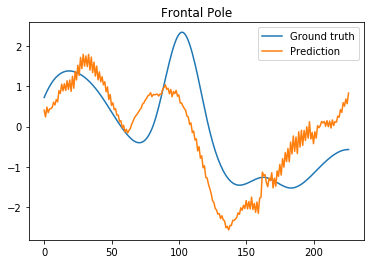

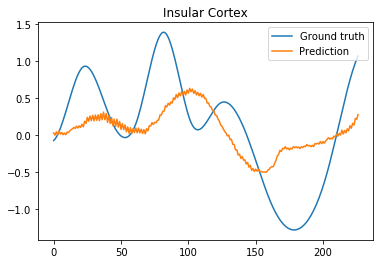

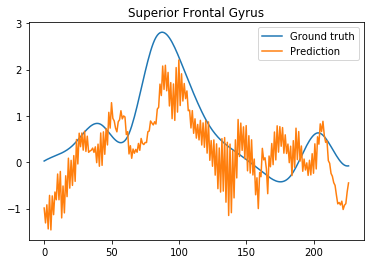

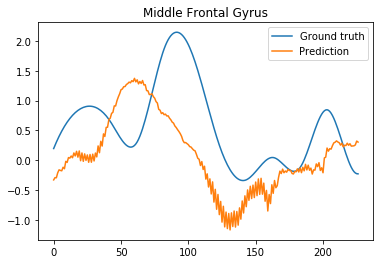

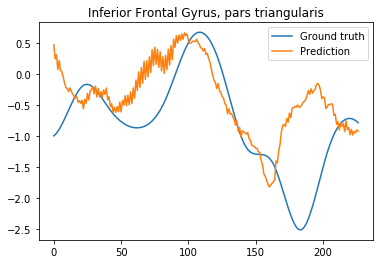

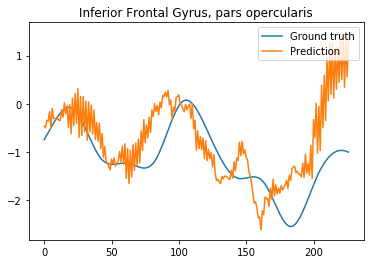

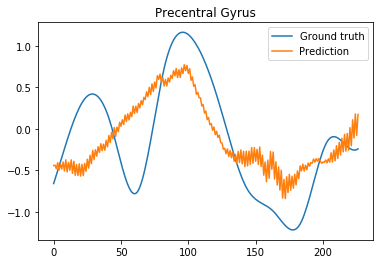

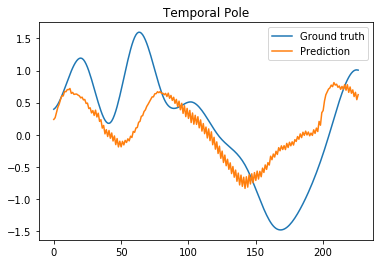

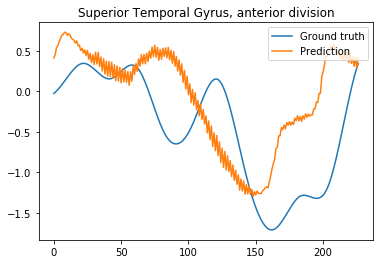

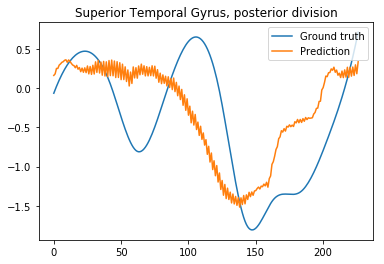

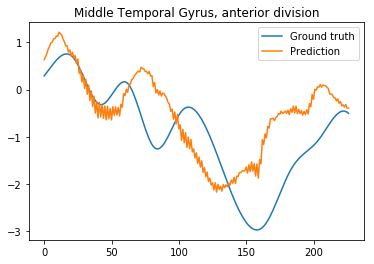

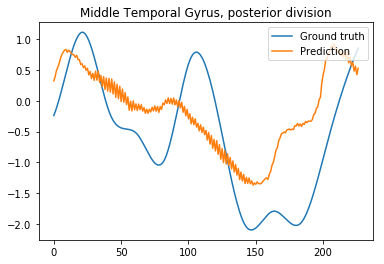

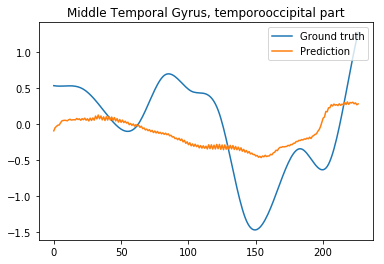

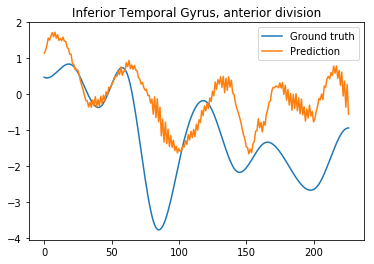

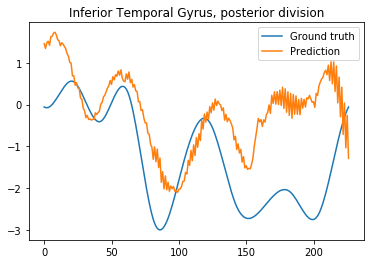

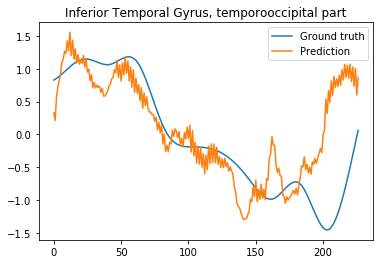

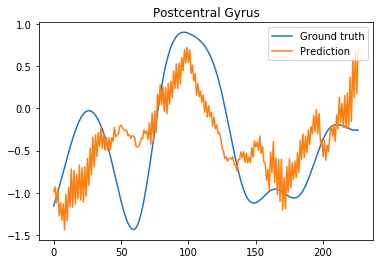

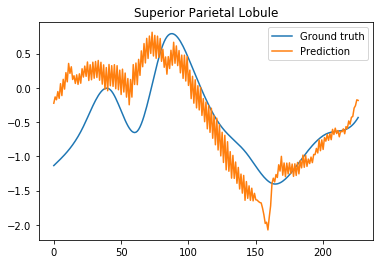

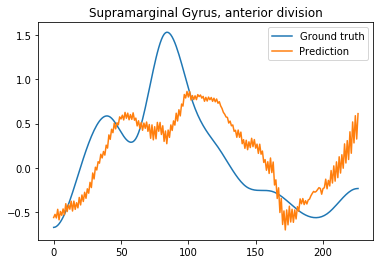

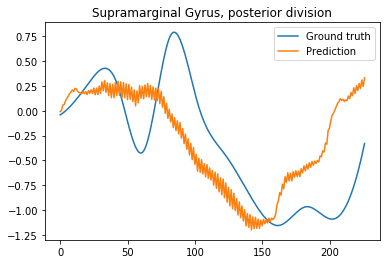

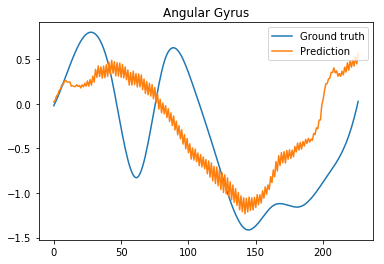

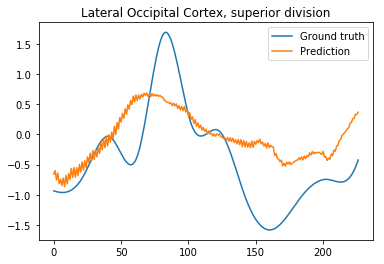

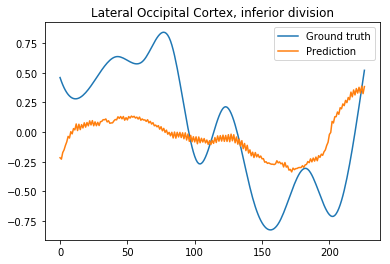

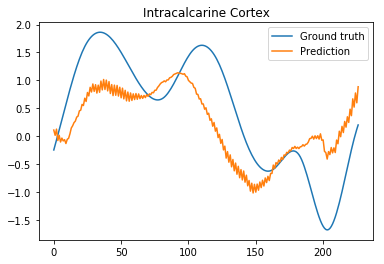

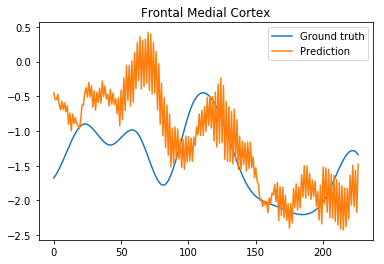

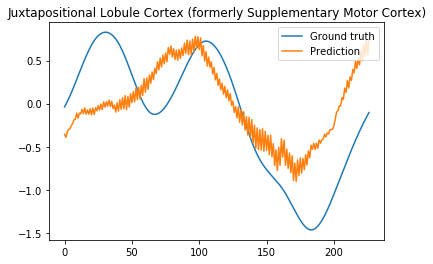

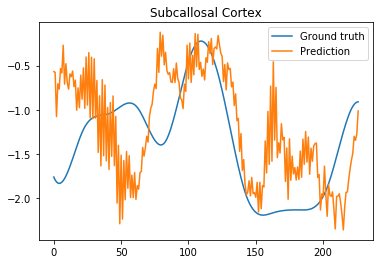

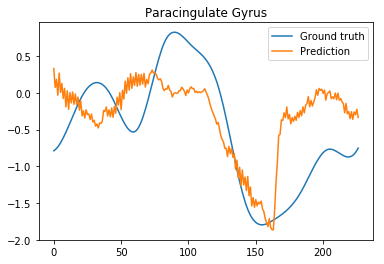

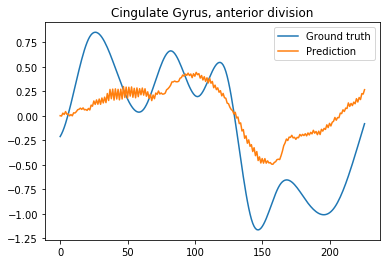

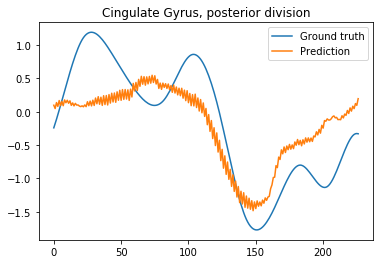

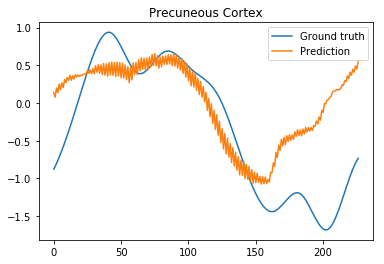

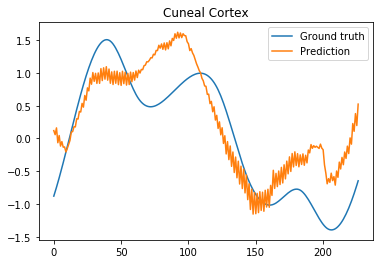

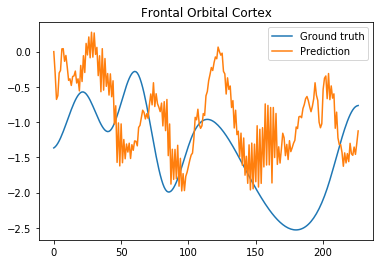

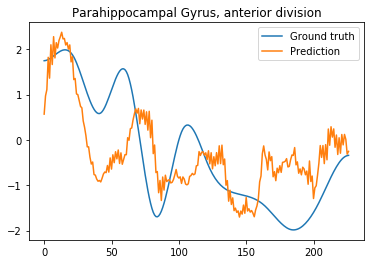

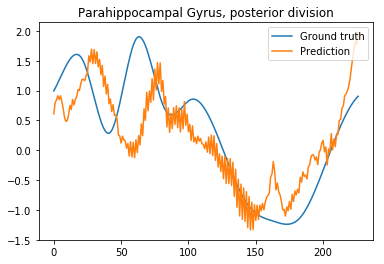

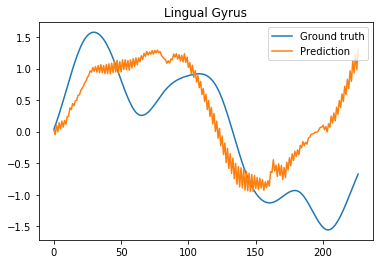

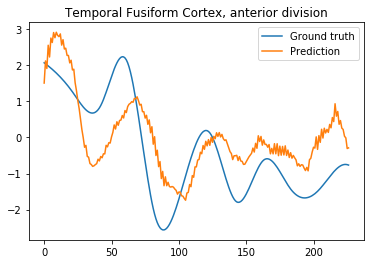

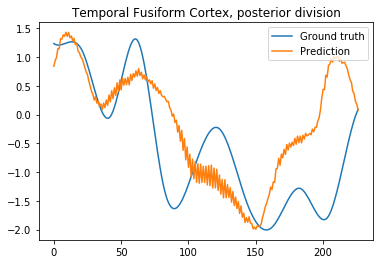

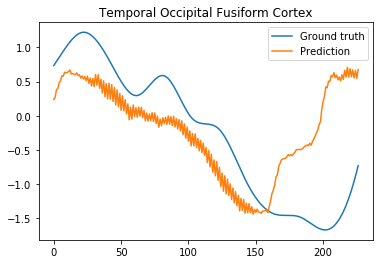

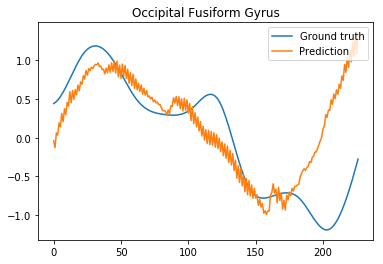

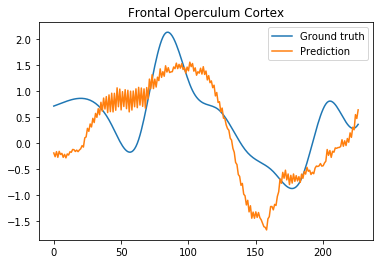

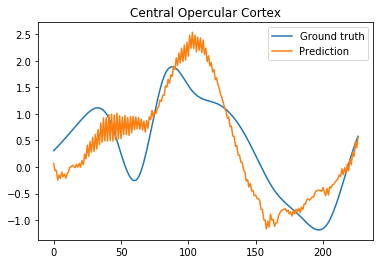

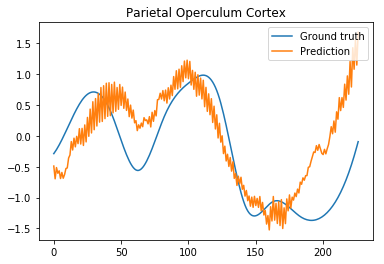

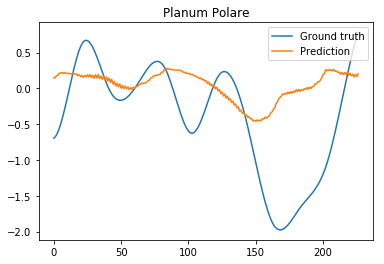

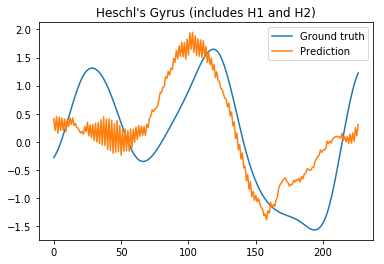

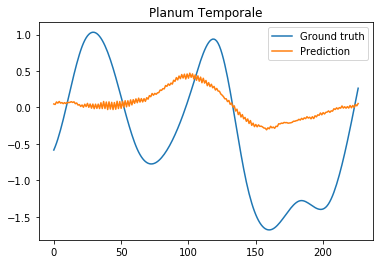

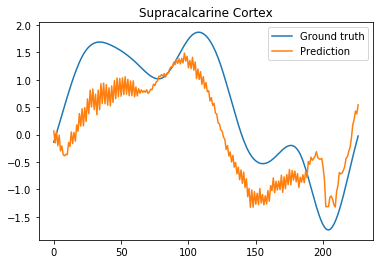

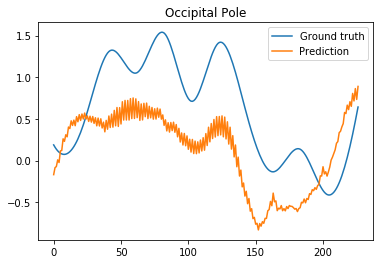

In [13]:
def norm(data):
    return (data)/(max(data)-min(data))
for i in range(len(labels)-1):
    lkl=bbb[i,R[i][0],R[i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lkl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
labels[11]

In [ ]:
for i in range(len(labels)-1):
    coefs=np.array(coefs)
    mean_coefs=coefs[i,:]
    max_coef = mean_coefs.max()
    mean_coefs=mean_coefs.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pcolormesh(np.linspace(-15,0,60),  ix_chs, mean_coefs, cmap='RdBu_r',
                  vmin=-max_coef, vmax=max_coef, shading='gouraud')
    #ax.axvline(time_plot, ls='--', color='k', lw=2)
    ax.set(xlabel='Delay (s)', ylabel='Freq_bands', title=labels[i+1])
    #plt.setp(ax.get_xticklabels(), rotation=45)
    mne.viz.tight_layout()

In [ ]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scoresfl= np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresr2fl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresmsefl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mmfl=[]
bbbfl=[]
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=True)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_fl_train)[0],-1), y_train[:,zone])
            predicted_y_testfl = ridgereg.predict(x_fl_test[:,a,:,:].reshape(np.shape(x_fl_test)[0],-1))
            scoresfl[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_testfl)[0]
            scoresr2fl[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_testfl)
            scoresmsefl[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_testfl)       
            t.append(ridgereg)
            nn.append(predicted_y_testfl)
            #models[zone,a,ii] = ridgereg
        s.append(t)
        jj.append(nn)
    mmfl.append(s)
    bbbfl.append(jj)
mmmfl=np.array(mmfl)
bbbfl=np.array(bbbfl)

In [ ]:
coefsfl=[]
scores_maxfl=[]
mmmfl=np.array(mmmfl)
Rfl=[]
for zone in range(len(labels)-1):
    ind = np.unravel_index((np.argmin(scoresmsefl[zone,...])), scores[zone,...].shape)
    coefsfl.append(mmmfl[zone, ind[0], ind[1]].coef_)
    scores_maxfl.append(scoresmsefl[zone,ind[0],ind[1]])
    Rfl.append(ind)
coefsfl=np.array(coefs)
mean_coefsfl=coefsfl[1,:]
max_coeffl = mean_coefsfl.max()

In [ ]:
scores_maxfl

In [ ]:
pp=[]
for i in range(len(labels)-1):
      pp.append(scores_maxfl[i]-scores_max[i])

In [ ]:
pp

In [ ]:
for i in range(len(labels)-1):
    lklfl=bbbfl[i,Rfl[i][0],Rfl[i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lklfl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
x_fl_train_new_list=[]
x_fl_test_new_list=[]
x_fl_train_1=np.roll(x_fl_train,100,axis=0)
x_fl_test_1=np.roll(x_fl_test,100,axis=0)
for zeta in range(100):
    x_train_fl_new=np.roll(x_fl_train_1,zeta*10,axis=0)
    x_test_fl_new=np.roll(x_fl_test_1,zeta*10,axis=0)
    x_fl_train_new_list.append(x_train_fl_new)
    x_fl_test_new_list.append(x_test_fl_new)
x_fl_train_new_list=np.array(x_fl_train_new_list)
x_fl_test_new_list=np.array(x_fl_test_new_list)
mmm=[]
for zeta1 in range(100):
    mmm1=[]
    for zone in range(len(labels)-1):
        mm=[]
        for a in range((np.shape(x_fl_test)[1])):
            s=[]
            for b in range((np.shape(x_fl_test)[3])):
                t=[]
                for ii, alpha in enumeralte(alphas):   
                    ridgereg = Ridge(alpha, normalize=True)
                    ridgereg.fit(x_fl_test_new_list[:,a,:,b], y_fl_train[:,zone])
                    predicted_y_fl_test = ridgereg.predict(x_fl_test[:,a,:,b])
                    scores[zone,a,b,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
                    t.append(ridgereg)
                #models[zone,a,ii] = ridgereg
                s.append(t)
            mm.append(s)
        mmm.append(mmm1)
mmm=np.array(mmm)

    